In [1]:
import os
os.chdir("..")

In [2]:
import multi_agent_reinforcement_learning
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [36]:
with open("data/scenario_shenzhen_downtown_west.json") as f:
    data = json.loads(f.read())

In [37]:
df = pd.DataFrame(data["demand"])

In [38]:
df.head()

,time_stamp,origin,destination,demand,travel_time,price
0,570,5,12,0.733333,14,18.2
1,570,7,10,0.133333,11,16.1
2,570,13,12,0.333333,10,13.7
3,570,9,12,0.733333,14,18.8
4,570,2,16,0.066667,30,47.6


# Simple summary stats

In [39]:
df_org_dest = df.groupby(["origin", "destination"]).agg({"price": ["count", "mean"], "demand": "mean", "travel_time":"mean"}).reset_index()

In [40]:
df_org_dest.head()

origin destination price               demand travel_time
                     count       mean      mean        mean
0      0           1   105  17.228571  0.142857    9.857143
1      0           2   120  15.462500  0.150000    9.750000
2      0           3   150  21.890000  0.120000   13.600000
3      0           5   105  27.628571  0.066667   16.142857
4      0           7    30  44.400000  0.066667   25.500000

In [41]:
df_org_dest.columns = df_org_dest.columns.droplevel(0)
df_org_dest.columns = ["Origin", "Destination", "count", "mean_price", "mean_demand", "mean_travel_time"]

In [42]:
df.describe()

,time_stamp,origin,destination,demand,travel_time,price
count,24375.000000,24375.000000,24375.000000,24375.000000,24375.000000,24375.000000
mean,569.680000,7.854154,7.886154,0.228308,16.562462,26.188738
std,52.000989,4.549476,4.595472,0.230287,9.463253,16.359750
min,480.000000,0.000000,0.000000,0.066667,3.000000,10.000000
25%,525.000000,4.000000,4.000000,0.066667,11.000000,15.900000
50%,569.000000,8.000000,8.000000,0.133333,14.000000,21.200000
75%,615.000000,12.000000,12.000000,0.266667,20.000000,30.500000
max,659.000000,16.000000,16.000000,1.533333,66.000000,128.500000


In [43]:
print(f"Origin nodes: {np.sort(df.origin.unique())}")
print(f"Destination nodes: {np.sort(df.destination.unique())}")

Origin nodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Destination nodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


# Grid analysis

In [44]:
pivot_df = df_org_dest.pivot(index='Origin', columns='Destination', values='count').T
pivot_df = pivot_df

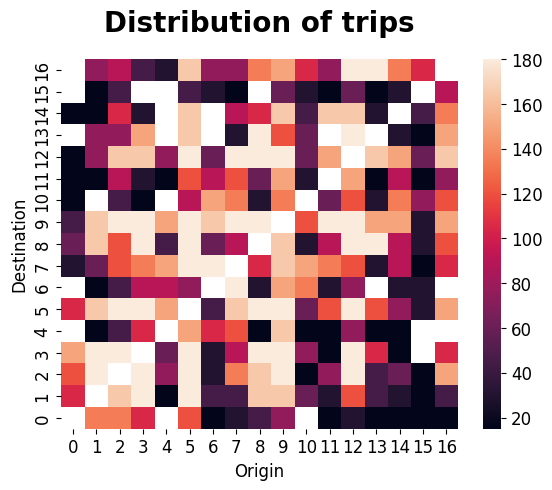

In [45]:
sns.heatmap(pivot_df.iloc[::-1], annot=False, fmt="d")
plt.title('Distribution of trips')
plt.xlabel(pivot_df.columns.name)
plt.ylabel(pivot_df.index.name)
plt.show()

In [124]:
mean_demand_matrix = df.groupby("origin")["demand"].mean().values.reshape(1,pivot_df.shape[1])

In [125]:
mean_demand_matrix

array([[0.10666667, 0.21407407, 0.26666667, 0.31638418, 0.10994152,
        0.35923567, 0.16296296, 0.19761905, 0.27977208, 0.32033543,
        0.10909091, 0.0982906 , 0.28735632, 0.1754386 , 0.12017544,
        0.07878788, 0.15301587]])

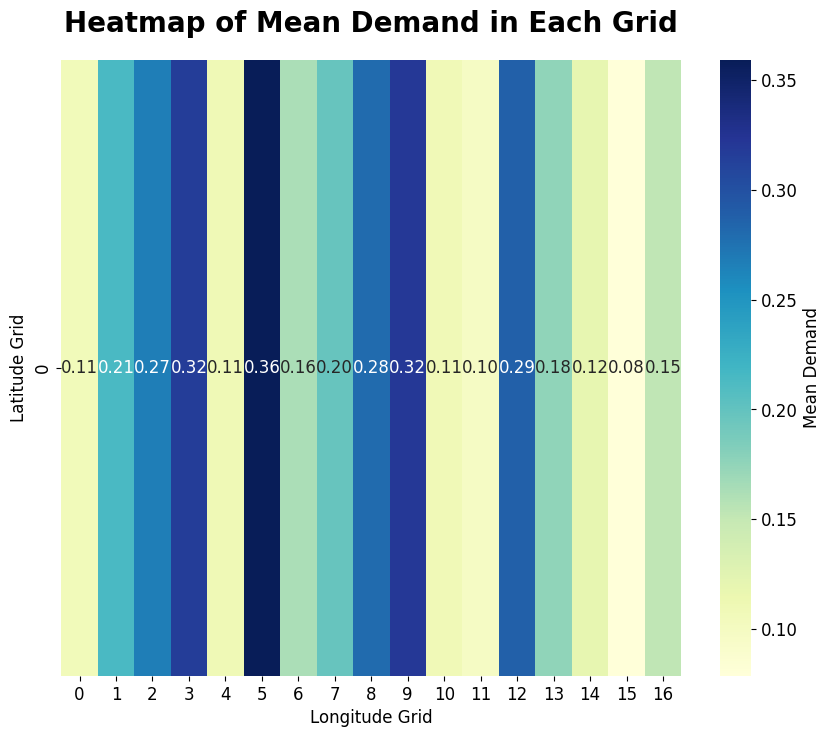

In [126]:
plt.figure(figsize=(10, 8))
sns.heatmap(mean_demand_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Demand'}, annot_kws={"size": 12})
plt.title('Heatmap of Mean Demand in Each Grid')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.show()

# Travel time analysis

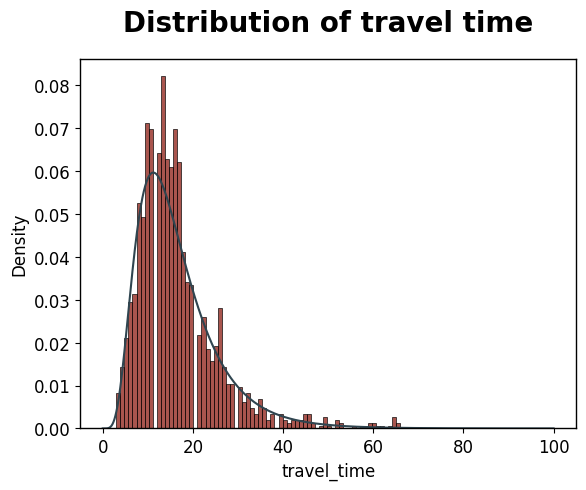

In [54]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["travel_time"])
sns.histplot(df["travel_time"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of travel time")
plt.show()

# Price analysis

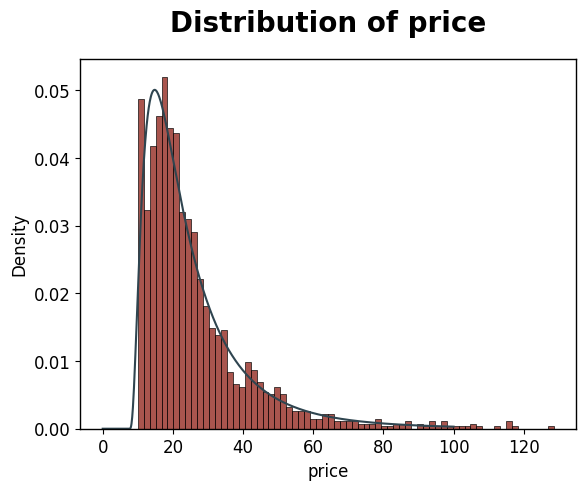

In [55]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["price"])
sns.histplot(df["price"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of price")
plt.show()

In [56]:
df.head()

,time_stamp,origin,destination,demand,travel_time,price
0,570,5,12,0.733333,14,18.2
1,570,7,10,0.133333,11,16.1
2,570,13,12,0.333333,10,13.7
3,570,9,12,0.733333,14,18.8
4,570,2,16,0.066667,30,47.6


In [57]:
pred_df = df.copy()

In [58]:
pred_df["poly_travel_time"] = pred_df["travel_time"]**2
pred_df["poly_demand"] = pred_df["demand"]**2
pred_df["log_price"] = np.log(pred_df["price"])

In [63]:
glm_model = smf.glm(formula="price ~ travel_time + demand", data=pred_df, family=sm.families.Gaussian())

In [64]:
fitted_glm = glm_model.fit()

In [65]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                24375
Model:                            GLM   Df Residuals:                    24372
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          12.655
Method:                          IRLS   Log-Likelihood:                -65518.
Date:                Tue, 14 Nov 2023   Deviance:                   3.0843e+05
Time:                        11:14:07   Pearson chi2:                 3.08e+05
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7455      0.054     13.728      0.000       0.639       0.852
travel_time     1.6467      0.002    675.996      0.000       1.642       1.652
demand         -8.0192      0.100    -80.109      0.000      -8.215      -7.823
===============================================================================
"""

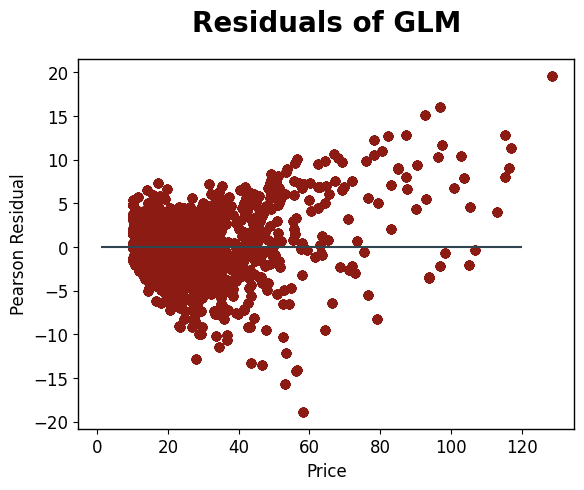

In [69]:
plt.scatter(pred_df["price"], pred_df["price"] - fitted_glm.predict())
plt.hlines(y=0, xmin=1, xmax=120, color="#2F4550")
plt.xlabel("Price")
plt.ylabel("Pearson Residual")
plt.title("Residuals of GLM")
plt.show()